In [1]:
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms

In [4]:
import sys
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/valukov-alex/knoledge_distilling/master/models.py -O models.py
    !wget https://raw.githubusercontent.com/valukov-alex/knoledge_distilling/master/train_utils.py -O train_utils.py

--2020-09-21 16:33:23--  https://raw.githubusercontent.com/valukov-alex/knoledge_distilling/master/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1781 (1.7K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]   1.74K  --.-KB/s    in 0s      

2020-09-21 16:33:23 (37.0 MB/s) - ‘models.py’ saved [1781/1781]

--2020-09-21 16:33:23--  https://raw.githubusercontent.com/valukov-alex/knoledge_distilling/master/train_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3936 (3.8K) [text/plain]
Saving 

In [5]:
from models import get_big_model, SmallCNN
from train_utils import train_hard_labels, train_soft_labels, test_model

In [6]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz
!tar zxvf imagewoof2-160.tgz

Streaming output truncated to the last 5000 lines.
imagewoof2-160/train/n02111889/n02111889_2643.JPEG
imagewoof2-160/train/n02111889/n02111889_14108.JPEG
imagewoof2-160/train/n02111889/n02111889_259.JPEG
imagewoof2-160/train/n02111889/n02111889_4237.JPEG
imagewoof2-160/train/n02111889/n02111889_5778.JPEG
imagewoof2-160/train/n02111889/n02111889_6356.JPEG
imagewoof2-160/train/n02111889/n02111889_8728.JPEG
imagewoof2-160/train/n02111889/n02111889_5679.JPEG
imagewoof2-160/train/n02111889/n02111889_9018.JPEG
imagewoof2-160/train/n02111889/n02111889_3146.JPEG
imagewoof2-160/train/n02111889/n02111889_5567.JPEG
imagewoof2-160/train/n02111889/n02111889_15505.JPEG
imagewoof2-160/train/n02111889/n02111889_15719.JPEG
imagewoof2-160/train/n02111889/n02111889_2944.JPEG
imagewoof2-160/train/n02111889/n02111889_11487.JPEG
imagewoof2-160/train/n02111889/n02111889_2867.JPEG
imagewoof2-160/train/n02111889/n02111889_12879.JPEG
imagewoof2-160/train/n02111889/n02111889_5968.JPEG
imagewoof2-160/train/n02111

# Загрузка данных

In [7]:
TRAIN_DATA_PATH = "imagewoof2-160/train"
VAL_DATA_PATH = "imagewoof2-160/val"
BATCH_SIZE = 128
TRANSFORM_TRAIN_IMG = transforms.Compose([
    transforms.RandomResizedCrop(140, scale=(0.8, 1)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomCrop(size=128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #параметры взяты отсюда https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#load-data
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
])

TRANSFORM_TEST_IMG = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_data = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_TRAIN_IMG)
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

val_data = datasets.ImageFolder(root=VAL_DATA_PATH, transform=TRANSFORM_TEST_IMG)
val_data_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

# Большая модель

Для большой модели я выбрал resnet50 с предобученными весами на ImageNet (из pytorch)

In [8]:
big_model = get_big_model(num_classes = 10, pretrained=True).to(device)

In [9]:
lr = 1e-5
num_epochs = 10
train_hard_labels(big_model, train_data_loader, val_data_loader, 
                  num_epochs=num_epochs, lr = lr, device = device, log=True)

Epoch 0
Train: accuracy: 0.513, CE: 1.722
Validation: accuracy: 0.771, CE: 1.110
Epoch 1
Train: accuracy: 0.819, CE: 0.824
Validation: accuracy: 0.863, CE: 0.582
Epoch 2
Train: accuracy: 0.867, CE: 0.502
Validation: accuracy: 0.881, CE: 0.439
Epoch 3
Train: accuracy: 0.892, CE: 0.380
Validation: accuracy: 0.891, CE: 0.373
Epoch 4
Train: accuracy: 0.905, CE: 0.321
Validation: accuracy: 0.896, CE: 0.341
Epoch 5
Train: accuracy: 0.916, CE: 0.280
Validation: accuracy: 0.895, CE: 0.330
Epoch 6
Train: accuracy: 0.927, CE: 0.238
Validation: accuracy: 0.900, CE: 0.312
Epoch 7
Train: accuracy: 0.932, CE: 0.217
Validation: accuracy: 0.902, CE: 0.317
Epoch 8
Train: accuracy: 0.943, CE: 0.188
Validation: accuracy: 0.899, CE: 0.314
Epoch 9
Train: accuracy: 0.947, CE: 0.176
Validation: accuracy: 0.902, CE: 0.300


[0.7711885976075338,
 0.8625604479511326,
 0.8806312038686689,
 0.8905573937388649,
 0.8959022652074319,
 0.894629676762535,
 0.9004835836090608,
 0.9020106897429372,
 0.8987019597862052,
 0.9022652074319165]

# Дистилляция

Для эксперимента Посмотрим, как быстро научится небольшая сеть с мягкими лэйблами, по сравнению с твердыми. Также посмотрим на скорость обучения в зависимости от параметров alpha и T.
>$loss = alpha * soft\_loss * T^2 + (1 - alpha) * hard\_loss$  
>$soft\_loss = CrossEntropy(Softmax(distill\_logits/T), Softmax(teacher\_logits/T))$


In [19]:
lr = 2e-4
num_epochs = 30
results = dict()

In [20]:
small_model =SmallCNN().to(device)
results["hard"] = train_hard_labels(small_model, train_data_loader, val_data_loader, 
                                   num_epochs=num_epochs, lr=lr, device = device, log=False)
print(results["hard"][-1])

0.40162891320946803


Для температуры T=20 переберем alpha

In [21]:
T = 20
for alpha in [0.1, 0.5, 0.9, 0.99]:
    small_model = SmallCNN().to(device)
    exp_name = "soft_T{}_alpha{}".format(T, alpha)
    results[exp_name] = train_soft_labels(small_model, big_model, train_data_loader, 
                                         val_data_loader, num_epochs = num_epochs, 
                                         lr = lr, T = T, alpha = alpha, device = device)
    print("alpha = {}, acc = {:.3f}".format(alpha, results[exp_name][-1]))

alpha = 0.1, acc = 0.407
alpha = 0.5, acc = 0.413
alpha = 0.9, acc = 0.407
alpha = 0.99, acc = 0.418


Для alpha = 0.5 переберем температуры:

In [22]:
alpha = 0.5
for T in [1, 5, 100]:
    small_model = SmallCNN().to(device)
    exp_name = "soft_T{}_alpha{}".format(T, alpha)
    results[exp_name] = train_soft_labels(small_model, big_model, train_data_loader, 
                                         val_data_loader, num_epochs = num_epochs, 
                                         lr = lr, T = T, alpha = alpha, device = device)
    print("T = {}, acc = {:.3f}".format(T, results[exp_name][-1]))

T = 1, acc = 0.414
T = 5, acc = 0.423
T = 100, acc = 0.398


In [23]:
# Сравнение точности
for exp, val_arr in results.items():
    print(exp)
    print(val_arr[-1])

hard
0.40162891320946803
soft_T20_alpha0.1
0.4074828200559939
soft_T20_alpha0.5
0.41308220921354033
soft_T20_alpha0.9
0.40671926698905575
soft_T20_alpha0.99
0.41817256299312805
soft_T1_alpha0.5
0.4135912445914991
soft_T5_alpha0.5
0.42275388139475695
soft_T100_alpha0.5
0.39832018325273605


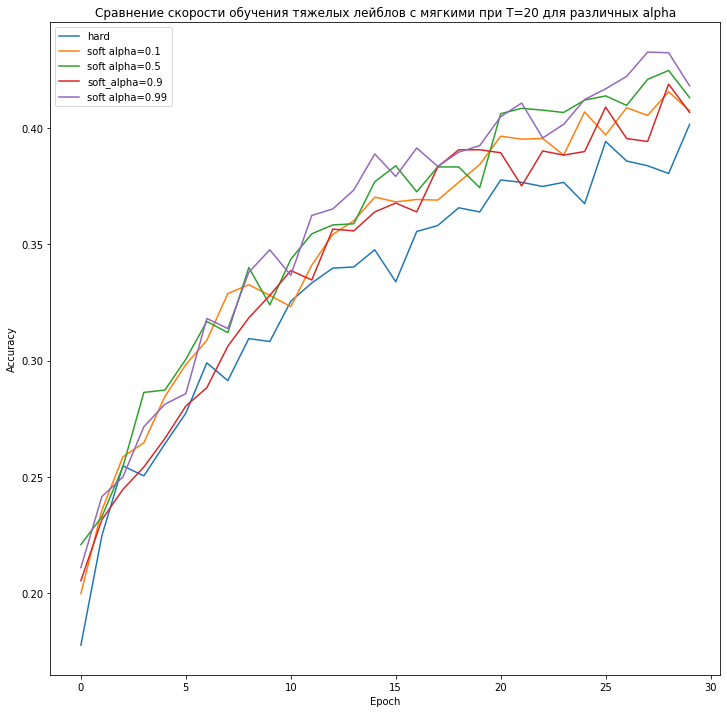

In [29]:
# Графики
from matplotlib import pyplot as plt

plt.figure(figsize = (12, 12))

plot1_exps = ["hard", "soft_T20_alpha0.1", "soft_T20_alpha0.5", "soft_T20_alpha0.9",
              "soft_T20_alpha0.99"]
plot1_legend = ["hard", "soft alpha=0.1", "soft alpha=0.5", "soft_alpha=0.9",
                "soft alpha=0.99"]

for plot_exp in plot1_exps:
    plt.plot(results[plot_exp])

plt.legend(plot1_legend)

plt.title("Сравнение скорости обучения тяжелых лейблов с мягкими при Т=20 для различных alpha")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

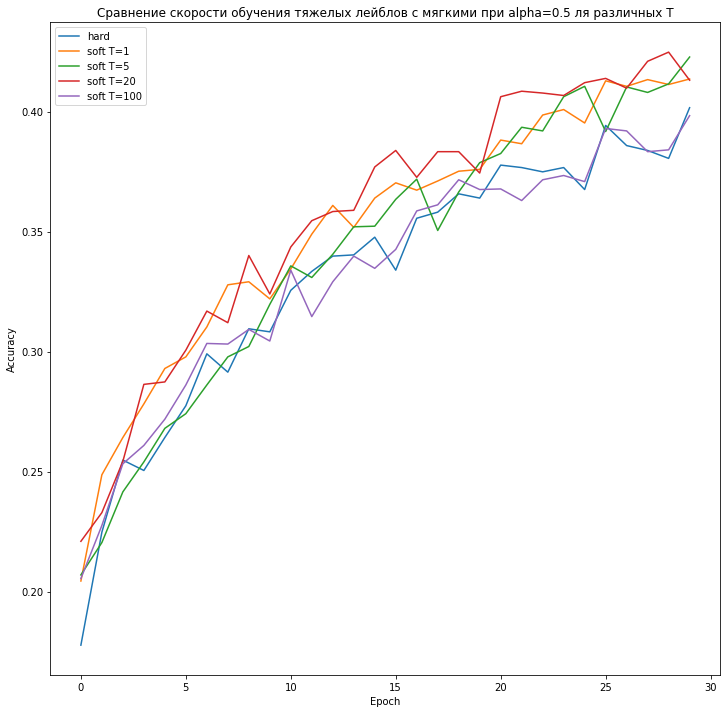

In [33]:
plt.figure(figsize = (12, 12))

plot2_exps = ["hard", "soft_T1_alpha0.5", "soft_T5_alpha0.5", "soft_T20_alpha0.5",
              "soft_T100_alpha0.5"]
plot2_legend = ["hard", "soft T=1", "soft T=5", "soft T=20", "soft T=100"]

for plot_exp in plot2_exps:
    plt.plot(results[plot_exp])

plt.legend(plot2_legend)

plt.title("Сравнение скорости обучения тяжелых лейблов с мягкими при alpha=0.5 ля различных T")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()